In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import zipfile
import os

In [3]:
# Unzipping the dataset
zip_path = '/content/stop_NotStop_zip.zip'
extract_path = '/content/stop_NotStop'

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
except zipfile.BadZipFile:
    print("Error: The file is not a valid zip file. Please check the file and try again.")

In [14]:
# Define paths
data_dir = '/content/stop_NotStop'
stop_dir = os.path.join(data_dir, 'stop')
not_stop_dir = os.path.join(data_dir, 'not_stop')

In [15]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [16]:
# Load dataset
dataset = ImageFolder(data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [17]:
# Using CNN model (ResNet50)
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification: stop sign or not

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]


In [18]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [19]:
# Initialize criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/10], Loss: 0.3732
Epoch [2/10], Loss: 0.3278
Epoch [3/10], Loss: 0.1197
Epoch [4/10], Loss: 0.0631
Epoch [5/10], Loss: 0.0565
Epoch [6/10], Loss: 0.0378
Epoch [7/10], Loss: 0.0930
Epoch [8/10], Loss: 0.0271
Epoch [9/10], Loss: 0.1604
Epoch [10/10], Loss: 0.1359


In [21]:
# Save the trained model
torch.save(model.state_dict(), 'stop_sign_classifier_resnet50.pth')

In [27]:
# Load test images and classify
def classify_images(image_paths):
    model.eval()
    with torch.no_grad():
        for image_path in image_paths:
            image = Image.open(image_path).convert('RGB')
            x = transform(image).unsqueeze(0).to(device)
            output = model(x)
            _, predicted = torch.max(output.data, 1)
            prediction = "Stop" if predicted.item() == dataset.class_to_idx['stop'] else "Not Stop"

            # Display the image with prediction
            plt.imshow(image)
            plt.title(f'{os.path.basename(image_path)}: Prediction = {prediction}')
            plt.axis('off')
            plt.show()

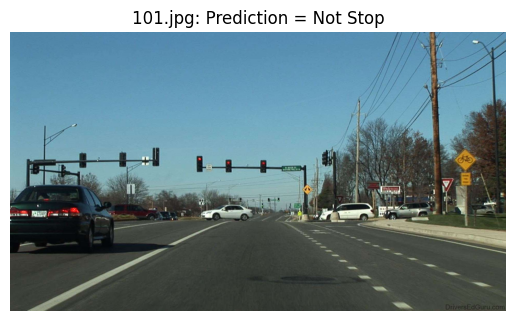

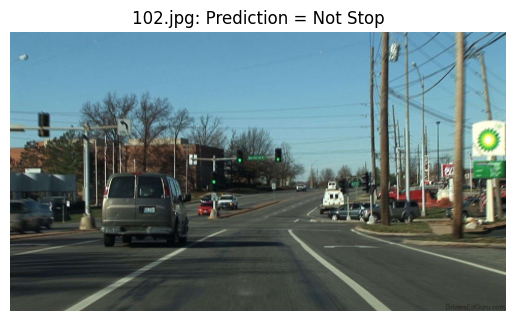

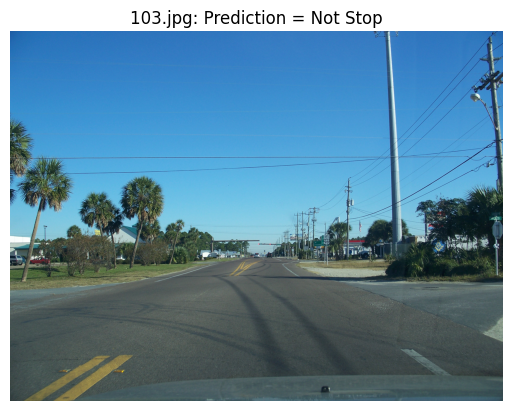

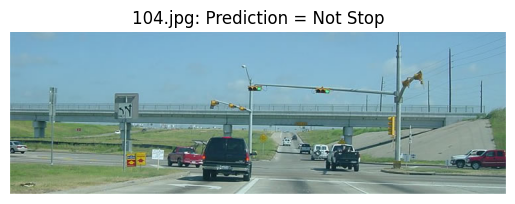

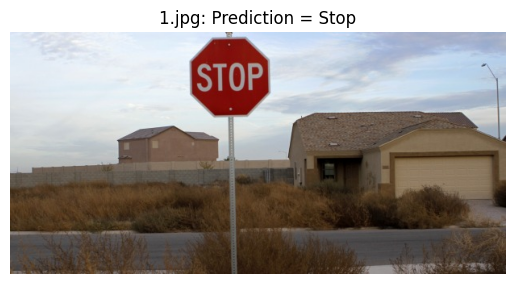

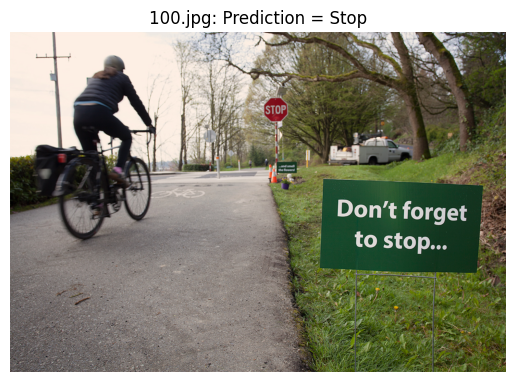

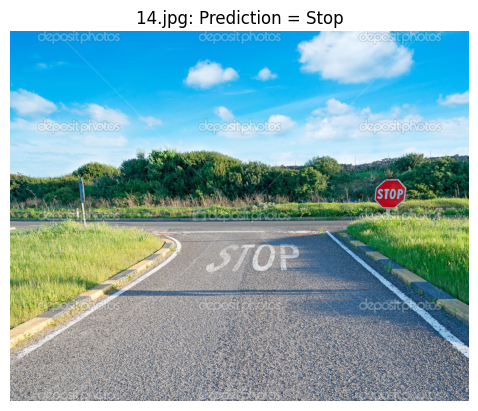

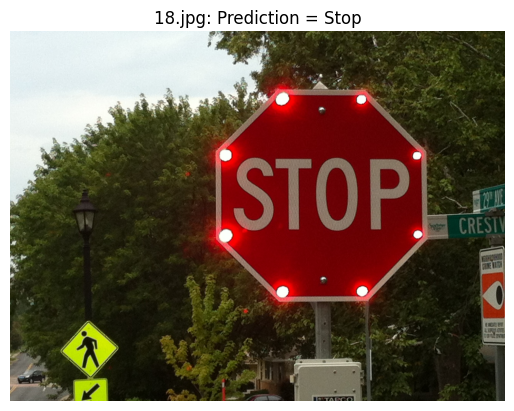

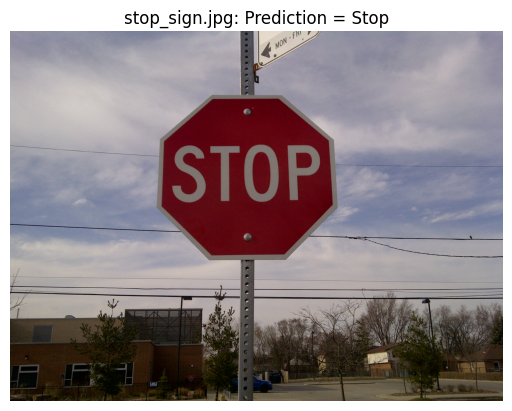

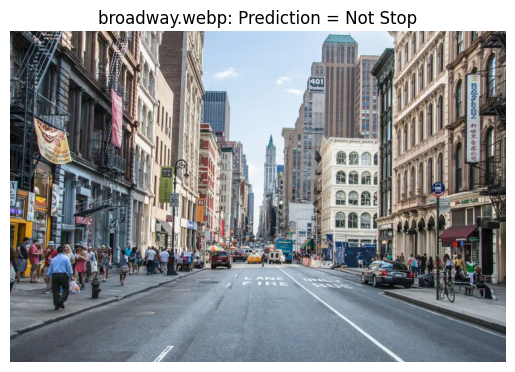

In [34]:
# Paths to test images
test_images = [
    '/content/stop_NotStop/not_stop/101.jpg',
    '/content/stop_NotStop/not_stop/102.jpg',
    '/content/stop_NotStop/not_stop/103.jpg',
    '/content/stop_NotStop/not_stop/104.jpg',
    '/content/stop_NotStop/stop/1.jpg',
    '/content/stop_NotStop/stop/100.jpg',
    '/content/stop_NotStop/stop/14.jpg',
    '/content/stop_NotStop/stop/18.jpg'
]

# Classify the test images
classify_images(test_images)

# Classify additional online images (assuming they are downloaded to these paths)
additional_images = [
    '/content/stop_sign.jpg',
    '/content/broadway.webp'


]

classify_images(additional_images)